# Sesión 2

In [727]:
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')
#Paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabr
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [728]:
# Librerias
import pandas as pd
import numpy as np
import sys
!{sys.executable} -m pip install pandas-profiling
!pip install vaderSentiment
!pip install seaborn
!pip install imbalanced-learn

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datetime import datetime


from sklearn.base import BaseEstimator, ClassifierMixin
import seaborn as sns
from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
Using cached joblib-1.1.1-py2.py3-none-any.whl (309 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.5.1 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling

1. Perfilamiento, entendimiento de los datos y  análisis de la calidad de los datos

Carga de datos

In [729]:
data_cargada=pd.read_csv('Data/fake_news_spanish.csv', sep=';', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data=data_cargada

In [730]:
data.head(10)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018
5,ID,1,"El PNV consolida su mayoría, el PSE salva los ...",Los nacionalistas consiguen las alcaldías de B...,26/05/2019
6,ID,0,El exconsejero Núria Marín pide el indulto en ...,Sus familiares aluden a su honestidad e integr...,16/09/2022
7,ID,1,La Fiscalía pide prisión incondicional para lo...,Suprime el delito de rebelión que les imputó i...,26/09/2019
8,ID,1,"José Manuel Pérez Tornero, el creador de la te...",El futuro presidente de RTVE es licenciado en ...,25/02/2021
9,ID,0,La 'Ayusización' del BNG: Santiago Abascal ins...,Pablo Santiago Abascal planea vivir de las ren...,10/05/2021


In [731]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


In [732]:
data.shape

(57063, 5)

En este punto del análisis, se puede ver que la unica columna que tiene datos nulos es Titulo, con un total de 16 datos nulos.

Inicializacion de variables

In [733]:
p = inflect.engine()
analyzer = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('spanish'))

### Entendimiento de los datos

In [734]:
from scipy import stats as st

textos_analisis = data.copy()
textos_analisis['Conteo_Titulo'] = [len(str(x)) for x in textos_analisis['Titulo']]
textos_analisis['Conteo_Descripcion'] = [len(str(x)) for x in textos_analisis['Descripcion']]

#textos_analisis['Moda'] =
textos_analisis['Max_Titulo'] = [[max([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Titulo']]
textos_analisis['Max_Titulo'] = [[max([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Titulo']]
textos_analisis['Min_Descripcion'] = [[min([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Descripcion']]
textos_analisis['Min_Descripcion'] = [[min([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Descripcion']]

textos_analisis  

,ID,Label,Titulo,Descripcion,Fecha,Conteo_Titulo,Conteo_Descripcion,Max_Titulo,Min_Descripcion
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,77,218,9,1
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,104,3251,10,1
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,77,169,10,2
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,110,133,12,2
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,72,242,11,1
...,...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,116,244,9,1
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,100,314,11,1
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,90,70,14,2
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,118,232,16,1


2. Preparación de los datos

Limpieza de datos y toquenización 

In [735]:
# Convertir columnas de texto a string
data['Titulo'] = data['Titulo'].astype('string')
data['Descripcion'] = data['Descripcion'].astype('string')

# Convertir Fecha a datetime
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y')
df=data

Vamos a buscar los datos Nulos


In [736]:
df.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

Revisemos que pasa en la columna titulo ya que es la unica fila que tiene titulos vacios

In [737]:
df[df.isna().any(axis=1)]

,ID,Label,Titulo,Descripcion,Fecha
3243,ID,0,<NA>,"Hace unos 75 años, Hermann Göring testificó en...",2019-06-16
4189,ID,0,<NA>,"Evidentemente, Barak Obama ha sido arrestado e...",2022-03-10
5041,ID,0,<NA>,"""Después de convertirme en presidente, le pedí...",2022-03-16
5644,ID,0,<NA>,Me pasaron de buena fuente hoy (un vecino del ...,2023-04-08
7345,ID,0,<NA>,Defienden dichos con capitulos de Don Gato. C...,2023-07-02
7652,ID,0,<NA>,Lean (y vean la imagen) con mucha atención: S...,2018-08-04
9700,ID,0,<NA>,¿Sabías que Francisco Sagasti salió a marchar ...,2018-12-26
15159,ID,0,<NA>,Declarar a Bill Gates enemigo público y proces...,2024-08-02
19415,ID,0,<NA>,Con el fin de captar votos están dispuestos a ...,2017-10-28
24806,ID,0,<NA>,CUANDO LAS IMÁGENES HABLAN MÁS QUE PALABRAS. ...,2018-06-28


In [738]:
def imputar_titulo_desde_descripcion(titulo, descripcion, max_palabras=5):
    if pd.isna(titulo):  
        if isinstance(descripcion, str):  
            palabras = descripcion.split()  
            return ' '.join(palabras[:max_palabras])  
        return ''  
    return titulo  

print(f"Filas con Título nulo antes: {df['Titulo'].isna().sum()}")
df['Titulo'] = df.apply(lambda row: imputar_titulo_desde_descripcion(row['Titulo'], row['Descripcion']), axis=1)
print(f"Filas con Título nulo después: {df['Titulo'].isna().sum()}")

Filas con Título nulo antes: 16
Filas con Título nulo después: 0


In [739]:
df.dtypes

ID                     object
Label                   int64
Titulo                 object
Descripcion    string[python]
Fecha          datetime64[ns]
dtype: object

In [740]:
palabras_sospechosas = set([
    'secreto', 'impactante', 'milagrosa', 'urgente', 'impresionante', 'sorprendente', 'insólito',
    'descubierto', 'alerta', 'indignante', 'peligroso', 'exclusivo', 'aterrador', 'impresionante',
    'conspiración', 'oculto', 'prohibido', 'mentira', 'falso', 'desmentido', 'engaño',
    'corrupción', 'censurado', 'revelación', 'encubierto', 'manipulación', 'trampa',
    'milagro', 'cura', 'prohibida', 'veneno', 'dañino', 'tóxico', 'ilegal', 'secreto',
    'remedio', 'increíble', 'fantástico', 'desconocido', 'nunca visto', 'no quieren que sepas',
    'última hora', 'no creerás', 'nadie lo esperaba', 'urgente', 'alerta máxima', 'devastador',
    'infalible', 'descubre', 'inexplicable', 'definitivo', 'drástico', 'imperdible', 'viral',
    'terror', 'amenaza', 'pánico', 'apocalipsis', 'devastador', 'tragedia', 'colapso',
    'desastre', 'crisis', 'fracaso', 'fin del mundo', 'poderoso', 'letal', 'brutal',
    'gana dinero', 'secreto bancario', 'hack', 'truco', 'fórmula mágica', 'sistema infalible',
    'multiplica tu dinero', 'solución definitiva', 'inversión garantizada', 'fácil y rápido',
    'químico peligroso', 'cura definitiva', 'anticancerígeno', 'natural y seguro', 'sin efectos secundarios',
    'poder de la mente', 'médicos lo odian', 'ciencia lo confirma', 'demostrado',
    'impresionante', 'alucinante', 'no lo podrás creer', 'revolucionario', 'radical', 'inigualable',
    'impactante', 'sorprendente', 'irrepetible', 'shock', 'devastador', 'asombroso'
])

In [741]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')    
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [re.sub(r'[^\w\s]', '', word) for word in tokens if word.isalnum()]    
    # tokens = [p.number_to_words(word) if word.isdigit() else word for word in tokens]
    # tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)  # Devolver como cadena para TF-IDF

In [742]:
df['Titulo_procesado'] = df['Titulo'].apply(lambda x: preprocess_text(x))
df['Descripcion_procesado'] = df['Descripcion'].apply(lambda x: preprocess_text(x))

In [743]:
def extract_text_features(text):
    if not isinstance(text, str):
        return pd.Series([0, 0, 0, 0])
    tokens = word_tokenize(text.lower())
    num_palabras = len(tokens)
    tokens_lematizados = [lemmatizer.lemmatize(token) for token in tokens]
    num_sospechosas = sum(1 for palabra in tokens if palabra in palabras_sospechosas)
    sentimiento = analyzer.polarity_scores(text)['compound']
    num_exclamaciones = text.count('!') + text.count('¡')
    return pd.Series([num_palabras, num_sospechosas, sentimiento, num_exclamaciones])

In [744]:
df[['Numero_Palabras_Titulo', 'Numero_Sospechosas_Titulo', 'Sentimiento_Titulo', 'Exclamaciones_Titulo']] = df['Titulo'].apply(lambda x: extract_text_features(x))
df[['Numero_Palabras_Descripcion', 'Numero_Sospechosas_Descripcion', 'Sentimiento_Descripcion', 'Exclamaciones_Descripcion']] = df['Descripcion'].apply(lambda x: extract_text_features(x))

In [745]:
# df['Titulo_procesado'] = df['Titulo_procesado'].apply(contractions.fix) 

Normalización 

In [746]:
df

,ID,Label,Titulo,Descripcion,Fecha,Titulo_procesado,Descripcion_procesado,Numero_Palabras_Titulo,Numero_Sospechosas_Titulo,Sentimiento_Titulo,Exclamaciones_Titulo,Numero_Palabras_Descripcion,Numero_Sospechosas_Descripcion,Sentimiento_Descripcion,Exclamaciones_Descripcion
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,guardian va con sanchez necesita que su apuest...,el diario britanico publico este pasado jueves...,16.0,0.0,0.0,0.0,37.0,0.0,0.0000,0.0
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,revelan que el gobierno negocio la liberacion ...,revelan que el gobierno negocio la liberacion ...,18.0,0.0,0.0,0.0,595.0,3.0,-0.8177,0.0
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,el o nunca de joan fuster sobre el estatuto va...,el valencianismo convoca en castello su fiesta...,15.0,0.0,0.0,0.0,32.0,0.0,0.4767,0.0
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,iglesias alienta a yolanda diaz erc y eh bildu...,en politica igual que hay que negociar con los...,20.0,0.0,0.0,0.0,23.0,0.0,0.3400,0.0
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,puigdemont seria ninguna tragedia una repetici...,en una entrevista en el punt avui el lider de ...,12.0,1.0,0.0,0.0,47.0,0.0,0.3400,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,2021-06-08,el defensor del pueblo reclama a la comunidad ...,el gobierno regional han indicado que la atenc...,20.0,0.0,0.0,0.0,45.0,0.0,-0.2960,0.0
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,2020-09-08,el equo plantea ceder la presidencia de la com...,si la higiene democratica no lleva a esa exige...,20.0,0.0,0.0,0.0,54.0,0.0,-0.2960,0.0
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,2018-07-12,alberto garzon los borbones son unos ladrones ...,el coordinador federal de iu asegura que la mo...,15.0,0.0,0.0,0.0,12.0,0.0,0.0000,0.0
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,2022-02-13,vox exige entrar en el gobierno de castilla y ...,santiago abascal vox tiene el derecho y el deb...,22.0,0.0,0.0,0.0,48.0,0.0,-0.2960,0.0


In [747]:
# df['titulo_new'] = df['titulo_new'].apply(contractions.fix) 
# df['description_new'] = df['description_new'].apply(contractions.fix) 


# Regresion Logistica

In [748]:
cantidadSi = (df["Label"] == 1).sum()
cantidadNo = (df["Label"] == 0).sum()
print(f"Noticias Verdaderas (1): {cantidadSi}")
print(f"Noticias Falsas (0): {cantidadNo}")

Noticias Verdaderas (1): 33158
Noticias Falsas (0): 23905


In [749]:
tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(df['Titulo'] + ' ' + df['Descripcion']).toarray()  # Original
#X_tfidf = tfidf.fit_transform(df['Titulo_procesado'] + ' ' + df['Descripcion_procesado']).toarray() # Si es que lo hago con datos preprocesados
X_tfidf_df = pd.DataFrame(X_tfidf, columns=[f'tfidf_{i}' for i in range(X_tfidf.shape[1])])


In [750]:
print(X_titulo_tfidf)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [751]:
X = pd.concat([df[['Numero_Palabras_Titulo', 'Numero_Sospechosas_Titulo', 'Sentimiento_Titulo', 'Exclamaciones_Titulo',
                   'Numero_Palabras_Descripcion', 'Numero_Sospechosas_Descripcion', 'Sentimiento_Descripcion', 'Exclamaciones_Descripcion']],
               X_tfidf_df], axis=1)
y = df['Label']

In [752]:
X = X.astype(float)

In [753]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [754]:
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train_balanced, y_train_balanced)

/Users/marcosrodrigo/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [755]:
y_pred = modelo.predict(X_test)
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nReporte completo:")
print(classification_report(y_test, y_pred, target_names=['Falsa', 'Verdadera']))

Precisión del modelo: 86.26%

Reporte completo:
              precision    recall  f1-score   support

       Falsa       0.88      0.78      0.83      5999
   Verdadera       0.85      0.92      0.89      8267

    accuracy                           0.86     14266
   macro avg       0.87      0.85      0.86     14266
weighted avg       0.86      0.86      0.86     14266



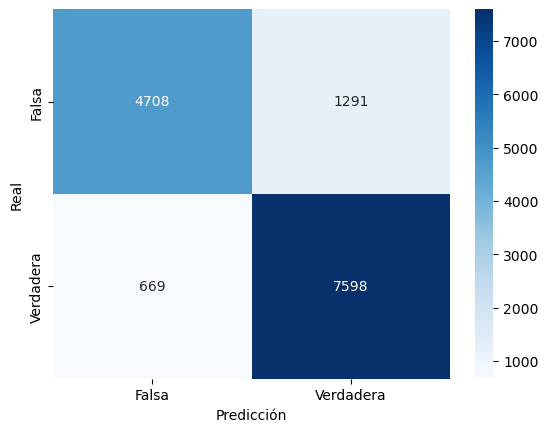

In [756]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadera'], yticklabels=['Falsa', 'Verdadera'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()